In [145]:
import datetime
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import dask
import dask.array as da
from google.cloud import storage
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 

In [146]:
imageio.plugins.freeimage.download()

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%147456/4830080 bytes (3.1%409600/4830080 bytes (8.5%688128/4830080 bytes (14.2950272/4830080 bytes (19.71245184/4830080 bytes (25.8%1441792/4830080 bytes (29.9%1769472/4830080 bytes (36.6%2129920/4830080 bytes (44.1%2441216/4830080 bytes (50.5%2998272/4830080 bytes (62.1%3538944/4830080 bytes (73.3%4259840/4830080 bytes (88.2%4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [140]:
root = '/home/jovyan/work/data/big_earth'
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

project_name = "cloud_and_shadow"
npy_image_dir = root + "/npy_image_files"
png_image_dir = root + "/png_image_files"

In [3]:
import json
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

(1, 44)
(1,)


In [4]:
# len(pd.read_csv(root + '/google_automl_cloud_and_shadow_dataset.csv'))

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

sample_no_cloud = train[train['has_cloud_and_shadow'] == 0]
sample_cloud = train[train['has_cloud_and_shadow'] == 1]


print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

1907 253 240
True


In [7]:
print('\n')
google_automl_dataset[['set', 'gcs_uri', 'label']].reset_index()[['set', 'gcs_uri', 'label']].head(5)

,set,gcs_uri,label
0,TRAIN,gs://big_earth_us_central_1/png_image_files/S2...,no_cloud_and_shadow
1,TRAIN,gs://big_earth_us_central_1/png_image_files/S2...,no_cloud_and_shadow
2,TRAIN,gs://big_earth_us_central_1/png_image_files/S2...,no_cloud_and_shadow
3,TRAIN,gs://big_earth_us_central_1/png_image_files/S2...,no_cloud_and_shadow
4,TRAIN,gs://big_earth_us_central_1/png_image_files/S2...,no_cloud_and_shadow


In [5]:
large = pd.read_csv(root + '/google_automl_dataset_large.csv')
large['image_prefix'] = large['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
large = large.set_index('image_prefix', drop=False)

small = pd.read_csv(root + '/google_automl_cloud_and_shadow_dataset_small.csv')
small['image_prefix'] = small['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
small = small.set_index('image_prefix', drop=False)

In [8]:
if not os.path.exists(root + '/cloud_and_shadow_stats_large_train.csv'):
    large_train = large[large['set'] == 'TRAIN']
    print(len(large_train))
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in large_train['image_prefix'].values]
    band_stats = stats_for_numpy_images(npy_files, use_test_data=False)    
    band_stats['dataset'] = 'large_train'
    pd.DataFrame(band_stats).to_csv(root + '/cloud_and_shadow_stats_large_train.csv')
else:
    band_stats = pd.read_csv(root + '/cloud_and_shadow_stats_large_train.csv')

In [17]:
if not os.path.exists(root + '/cloud_and_shadow_stats_small_train.csv'):
    small_train = small[small['set'] == 'TRAIN']
    print(len(small_train))
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in small_train['image_prefix'].values]
    stats = stats_for_numpy_images(npy_files, use_test_data=False)
    stats['dataset'] = 'small_train'
    pd.DataFrame(stats).to_csv(root + '/cloud_and_shadow_stats_small_train.csv')
else:
    band_stats = pd.read_csv(root + '/cloud_and_shadow_stats_large_train.csv')

cloud = small[small['label'] == 'has_cloud_and_shadow']
no_cloud = small[small['label'] == 'no_cloud_and_shadow'] 



In [21]:
if os.path.exists(root + '/cloud_and_shadow_stats_all.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats_all.csv')
else:
    stat_list = []
    
    all_dataset = pd.DataFrame({'mean': [783.130904, 923.677824,  912.063215], 
          'std': [1562.511727, 1436.245623, 1527.788724], 
          'min': [0, 0, 0], 
          'max': [20566, 18989, 17881]}, index=['red', 'blue', 'green'])

    all_dataset['dataset'] = 'all'
    stat_list.append(all_dataset)
    
    all_cloud =  df[df['has_cloud_and_shadow'] == 1]
    print('len(all_cloud)', len(all_cloud))
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in all_cloud['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['dataset'] = 'all_cloud'
    stat_list.append(stats)
    
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in large['image_prefix'].values]
    stats = stats_for_numpy_images(npy_files, use_test_data=False)    
    stats['dataset'] = 'all_large'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = large[large['label'] == 'no_cloud_and_shadow']
    for name, data in [('no_cloud_large', no_cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['dataset'] = name
        stat_list.append(stats)    
    
    cloud = small[small['label'] == 'has_cloud_and_shadow']
    no_cloud = small[small['label'] == 'no_cloud_and_shadow']    
    print(len(no_cloud), len(cloud))
    for name, data in [('no_cloud_small', no_cloud), ('cloud_small', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['dataset'] = name
        stat_list.append(stats)  
        
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats_all.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

len(all_cloud) 9280
1200 1200
stats computed in 1207.6733849048615


In [12]:
band_stats['mean'] = band_stats['mean'].astype(int)
band_stats['std'] = band_stats['std'].astype(int)

band_stats

,Unnamed: 0,mean,std,min,max,dataset
0,red,942,1738,0,19737,large_train
1,blue,1064,1607,0,18347,large_train
2,green,1014,1670,0,17815,large_train


In [10]:
# no_cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in no_cloud['image_prefix'].values]
# no_cloud_pixels = np.concatenate([np.load(file).reshape(120 * 120, 3) for file in no_cloud_npy_files])
# assert no_cloud_pixels.shape == (len(no_cloud_npy_files) * 120 * 120, 3)

In [11]:
# cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in cloud['image_prefix'].values]
# cloud_pixels = np.concatenate([np.load(file).reshape(120 * 120, 3) for file in cloud_npy_files])

In [12]:
# dfs = []
# for pixels, dataset_name in [(cloud_pixels, 'has_cloud'), (no_cloud_pixels, 'no_cloud')]:
#     for band_name, band_idx in [('red', 0),  ('blue', 1), ('green', 2)]:
#         df = pd.DataFrame({'pixel': cloud_pixels[:, band_idx]})
#         df['band'] = band_name
#         df['dataset'] = dataset_name
#         dfs.append(df)

# pixel_df = pd.concat(dfs)

In [13]:
# pixel_df

In [14]:
# sns.catplot(x="dataset", y="pixel", hue="band", kind="box", data=pixel_df);

In [17]:
all_stats['index'] = all_stats.index
melted = all_stats.drop(['max'], axis=1).melt(value_name='pixel', var_name='stat', id_vars=['index', 'band', 'data'])

<ErrorbarContainer object of 3 artists>

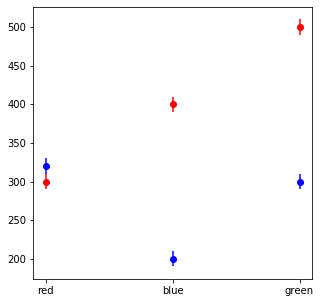

In [18]:
d = pd.DataFrame({'std': [10, 10 , 10],  'mean': [300, 400, 500], 
                  'band': ['red',  'blue', 'green'], 'dataset': ['no_cloud', 'no_cloud', 'no_cloud']})
d2 = pd.DataFrame({'std': [10, 10 , 10],  'mean': [320, 200, 300], 
                  'band': ['red',  'blue', 'green'], 'dataset': ['cloud', 'cloud', 'cloud']})
# plt.scatter(d['band'], d['mean'])
# plt.errorbar(d['band'],d['mean'],yerr=d['std'], linestyle="None")
# plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(d['band'], d['mean'], yerr=d['std'], fmt="-o", mec='r', mfc='r', linestyle="None", label='no cloud', 
            **dict(ecolor='r'))
ax.errorbar(d2['band'], d2['mean'], yerr=d2['std'], fmt="-o", mec='b', mfc='b', linestyle="None", label='cloud', 
            **dict(ecolor='b'))


<ErrorbarContainer object of 3 artists>

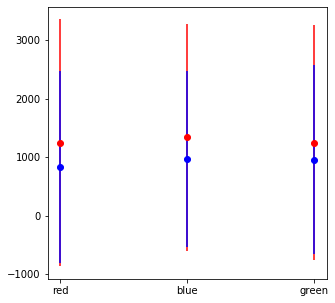

In [19]:
cloud_stats = all_stats[all_stats['data'] == 'cloud']
no_cloud_stats = all_stats[all_stats['data'] == 'no_cloud']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(cloud_stats['band'], cloud_stats['mean'], yerr=cloud_stats['std'], fmt="-o", mec='r', mfc='r', linestyle="None", label='cloud', 
            **dict(ecolor='r'))
ax.errorbar(no_cloud_stats['band'], no_cloud_stats['mean'], yerr=no_cloud_stats['std'], fmt="-o", mec='b', mfc='b', linestyle="None", label='no_cloud', 
            **dict(ecolor='b'))

NameError: name 'melted' is not defined

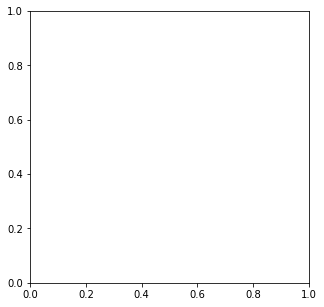

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
s = sns.scatterplot(x='band', y='pixel', hue='data', data=melted, style='stat', 
                markers={'mean': 'o', 'max': '^', 'min': 'v', 'std': 'X'}, 
                ax=ax)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [101]:
cloud_stats = all_stats[all_stats['dataset'].isin(['all_cloud', 'cloud'])].set_index(['dataset', 'band']).astype(float)
(cloud_stats.loc['all_cloud'] - cloud_stats.loc['cloud']) / cloud_stats.loc['cloud'] * 100

,mean,std,min,max
band,,,,
red,-10.064412,-9.047845,-100.0,1.836688
blue,-8.764045,-8.187436,-100.0,0.844133
green,-9.623095,-8.918784,-100.0,2.091818


In [105]:
no_cloud_stats = all_stats[all_stats['dataset'].isin(['all', 'no_cloud'])].set_index(['dataset', 'band']).astype(float)
(no_cloud_stats.loc['all'] - no_cloud_stats.loc['no_cloud']) / no_cloud_stats.loc['no_cloud'] * 100

,mean,std,min,max
band,,,,
red,-5.205811,-4.697987,NaN,8.550618
blue,-4.153686,-4.648074,NaN,5.959489
green,-4.801670,-4.919054,NaN,4.787857


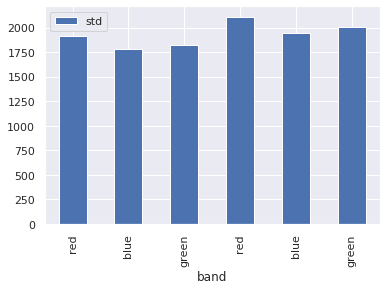

In [80]:
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["medium blue"]
green = sns.xkcd_rgb["green"]

sns.set()
all_stats[all_stats['dataset'].isin(['all_cloud', 'cloud'])].set_index('dataset').plot(kind='bar', x='band', y='std')

# cplt = sns.catplot(x="dataset", y="std", hue="band", kind="bar", data=all_stats, 
#             palette={'red': red, 'blue': blue, 'green': green}).set_titles('std')
# cplt.fig.suptitle('Pixel std by dataset and band')


In [39]:
def rename(row):
    if row['dataset'] == 'all_cloud':
        row['dataset'] = 'cloud_large'
    return row
all_stats = all_stats.apply(rename, axis=1)
all_stats = all_stats.sort_values(by='dataset')

Text(0.5, 0.98, 'Pixel std by dataset and band')

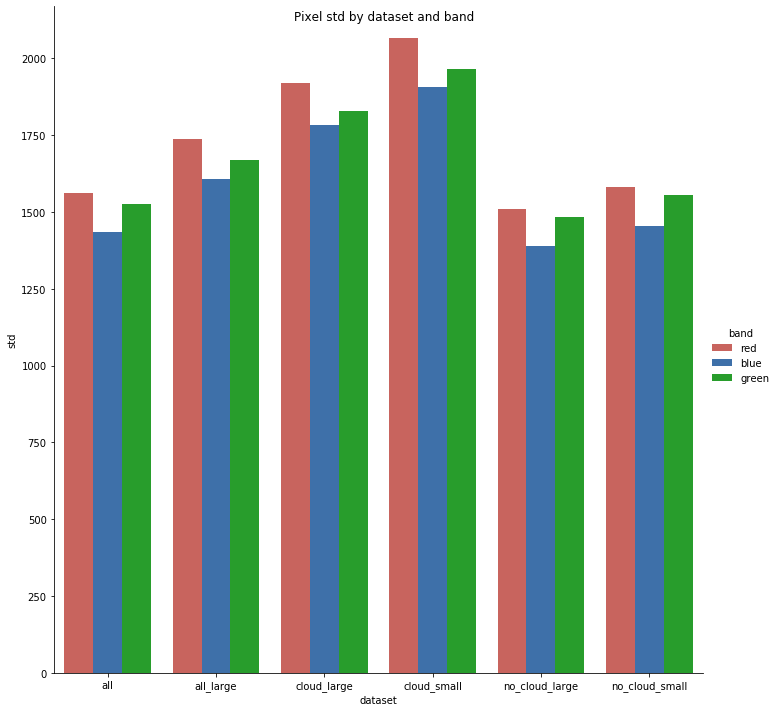

In [42]:
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["medium blue"]
green = sns.xkcd_rgb["green"]

cplt = sns.catplot(height=10, x="dataset", y="std", hue="band", kind="bar", data=all_stats, 
            palette={'red': red, 'blue': blue, 'green': green}).set_titles('std')
cplt.fig.suptitle('Pixel std by dataset and band')

Text(0.5, 0.98, 'Pixel mean by dataset and band')

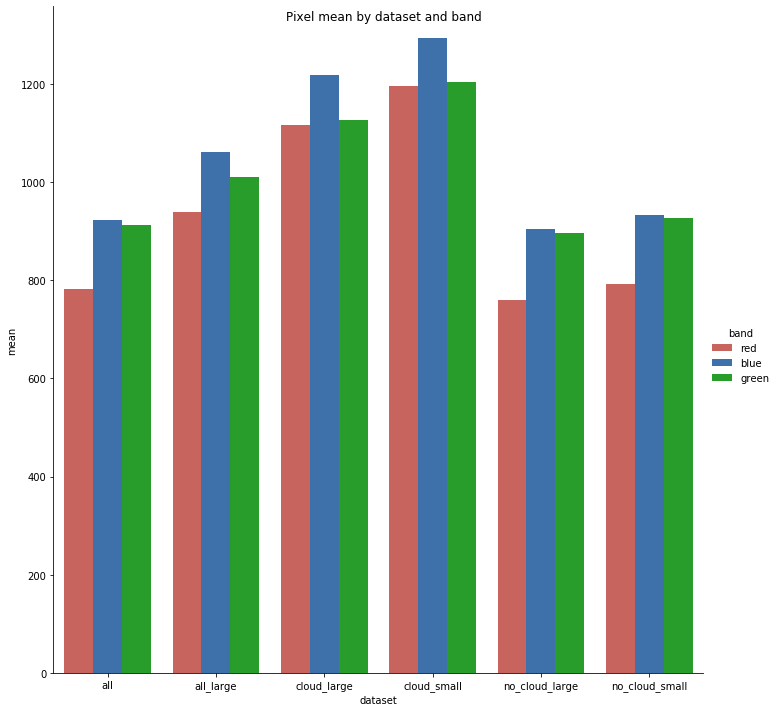

In [41]:
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["medium blue"]
green = sns.xkcd_rgb["green"]

cplt = sns.catplot(height=10, x="dataset", y="mean", hue="band", kind="bar", data=all_stats, 
            palette={'red': red, 'blue': blue, 'green': green}).set_titles('mean')

cplt.fig.suptitle('Pixel mean by dataset and band')
# cplt.fig.figsize((15, 15))

In [ ]:
sns.catplot(x="data", y="min", hue="band", kind="bar", data=all_stats, 
            palette={'red': 'red', 'blue': 'blue', 'green': 'green'}).set_titles('min')

In [ ]:
sns.catplot(x="data", y="max", hue="band", kind="bar", data=all_stats, 
            palette={'red': 'red', 'blue': 'blue', 'green': 'green'}).set_titles('max')

In [21]:
stats = band_stats[band_stats['dataset'] == 'all']
means = np.array(band_stats['mean'])
stds = np.array(band_stats['std'])
mins = np.array(band_stats['min'])
maxs = np.array(band_stats['max'])

In [ ]:
# https://stackoverflow.com/questions/14464449/using-numpy-to-efficiently-convert-16-bit-image-data-to-8-bit-for-display-with

def display(image, display_min, display_max): # copied from Bi Rico
    image = np.array(image, copy=True)
    image.clip(display_min, display_max, out=image)
    image -= display_min
    np.floor_divide(image, (display_max - display_min + 1) / 256,
                    out=image, casting='unsafe')
    return image.astype(np.uint8)

def lut_display(image, display_min, display_max) :
    lut = np.arange(2**16, dtype='uint16')
    lut = display(lut, display_min, display_max)
    return np.take(lut, image)

In [ ]:
def map_uint16_to_uint8(img, lower_bound=None, upper_bound=None):
    '''
    Map a 16-bit image trough a lookup table to convert it to 8-bit.

    Parameters
    ----------
    img: numpy.ndarray[np.uint16]
        image that should be mapped
    lower_bound: int, optional
        lower bound of the range that should be mapped to ``[0, 255]``,
        value must be in the range ``[0, 65535]`` and smaller than `upper_bound`
        (defaults to ``numpy.min(img)``)
    upper_bound: int, optional
       upper bound of the range that should be mapped to ``[0, 255]``,
       value must be in the range ``[0, 65535]`` and larger than `lower_bound`
       (defaults to ``numpy.max(img)``)

    Returns
    -------
    numpy.ndarray[uint8]
    '''
    if not(0 <= lower_bound < 2**16) and lower_bound is not None:
        raise ValueError(
            '"lower_bound" must be in the range [0, 65535]')
    if not(0 <= upper_bound < 2**16) and upper_bound is not None:
        raise ValueError(
            '"upper_bound" must be in the range [0, 65535]')
    if lower_bound is None:
        lower_bound = np.min(img)
    if upper_bound is None:
        upper_bound = np.max(img)
    if lower_bound >= upper_bound:
        raise ValueError(
            '"lower_bound" must be smaller than "upper_bound"')
    lut = np.concatenate([
        np.zeros(lower_bound, dtype=np.uint16),
        np.linspace(0, 255, upper_bound - lower_bound).astype(np.uint16),
        np.ones(2**16 - upper_bound, dtype=np.uint16) * 255
    ])
    return lut[img].astype(np.uint8)

In [114]:
import cv2 

def calibrate_image(rgb_image):
    # From https://www.kaggle.com/robinkraft/issue-with-tif-files
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*stds[i] + means[i]
#         min_pixel = np.min(calibrated_img[:,:,i])
#         max_pixel = np.max(calibrated_img[:,:,i])
#         calibrated_img[:,:,i] = cv2.normalize(calibrated_img[:,:,i], dst=None, alpha=min_pixel, 
#                                               beta=max_pixel, norm_type=cv2.NORM_MINMAX)
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)

    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

In [ ]:
# map_uint16_to_uint8(arr, np.min(mins), np.max(maxs))

In [13]:
stds = all_stats[all_stats['data'] == 'all']['std'].values
means = all_stats[all_stats['data'] == 'all']['mean'].values

In [150]:
def image_to_jpg(image_prefix):
    bands = [np.asarray(
        Image.open(f"{image_dir}/{image_prefix}/{image_prefix}_B{band}.tif"),
        dtype=np.uint16) for band in ["02", "03", "04"]]

    stacked_arr = np.stack(bands, axis=-1)
    np.save(f"{npy_files_path}/{image_prefix}", stacked_arr)

[]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44.113680555555554 18.849649222342645 -128 127
47.153125 29.507621456679143 -128 127
70.68030092592592 38.00187362464537 -128 127
49.52724537037037 37.2698691516174 -128 127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32.530902777777776 59.08493234491778 -128 127
6.119351851851852 73.21602780373763 -128 127
-27.95826388888889 72.05280563422701 -128 127
23.786851851851853 67.51097567348185 -128 127
49.60231481481482 33.79169364587172 -128 127


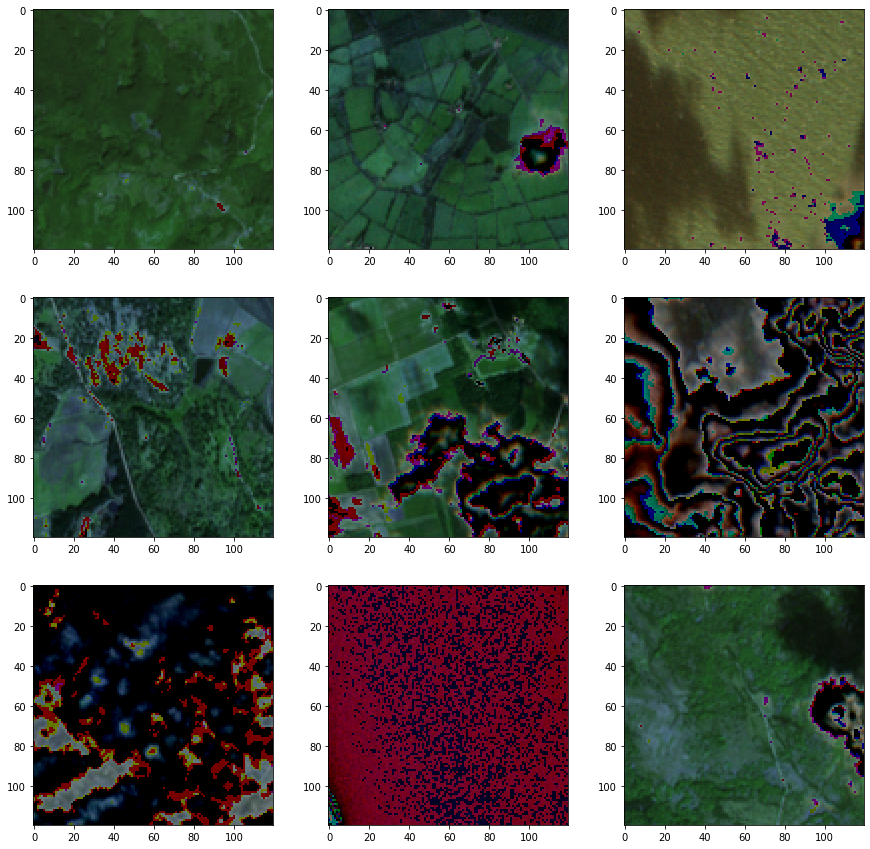

In [193]:
dim = 3
fig, axs = plt.subplots(dim, dim, **{'figsize': (15,  15)})

labels = []
npy_files = [npy_image_dir + "/" + file + ".npy" for file in small['image_prefix'].values]
img_nums = np.random.randint(0, len(small), size=9)
img_num_idx = 0
for row_num, row_axs in enumerate(axs):
    for col_num, ax in enumerate(row_axs):
        img_num = img_nums[img_num_idx]
        img_num_idx += 1
        arr = np.load(npy_files[img_num])
        # This method makes the images too bright and colorful
#         rgb_img = calibrate_image(arr, stds, means)
        # normalizing gives a produces images that are too dark
#         rgb_img = ((arr - means) / stds * 255.).astype(np.int8)
#         rgb_img = ((arr - np.mean(arr)) / np.std(arr) * 255.).astype(np.int8)        
#         scaling by .75 std away from the mean seems to do the best
#         rgb_img = np.clip(rgb_img, 0, 255).astype(np.uint8)    
#         rgb_img = (arr / (np.mean(arr) + .7*np.std(arr)) * 255.).astype(np.int8)        
        rgb_img = (arr / (means + .7*stds) * 255.).astype(np.int8)        
        # min max produces images that are all black
#         rgb_img = ((arr - mins) / (maxs - mins) * 255.).astype(np.int8)        
        # dividing by 256 produces images that are too white
#         rgb_img = arr / 256
        print(np.mean(rgb_img), np.std(rgb_img), np.min(rgb_img), np.max(rgb_img))

        ax.imshow(rgb_img)
#         text = list(map(lambda x: x.strip(), no_cloud.iloc[img_num]['labels'].replace('\'', '').replace('[', '').replace(']', '').split(',')))
        labels.append((row_num, col_num, df.loc[small.iloc[img_num]['image_prefix']]['has_cloud_and_shadow']))
    

In [195]:
(7 + 5 + 6 + 4 + 7 + 9 + 7 + 7 + 9 + 7 + 9 + 7) / (9 * 12)

0.7777777777777778

In [194]:
# 7/9
# 5/9
# 6/9
# 4/9

# 00 - n
# 01 - n - wrong
# 02 - n - wrong
# 10 - y - wrong
# 11 - n
# 12 - y
# 20 - y
# 21 - n
# 32 - n

for label in labels:
    print(label)

(0, 0, 0.0)
(0, 1, 1.0)
(0, 2, 1.0)
(1, 0, 0.0)
(1, 1, 1.0)
(1, 2, 1.0)
(2, 0, 1.0)
(2, 1, 1.0)
(2, 2, 0.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0 ['Non-irrigated arable land', 'Complex cultivation patterns', 'Coniferous forest']
0 1 ['Sea and ocean']
0 2 ['Broad-leaved forest', 'Mixed forest']
1 0 ['Land principally occupied by agriculture, with significant areas of natural vegetation', 'Broad-leaved forest']
1 1 ['Broad-leaved forest']
1 2 ['Coniferous forest', 'Mixed forest', 'Water bodies']
2 0 ['Land principally occupied by agriculture, with significant areas of natural vegetation', 'Coniferous forest', 'Mixed forest']
2 1 ['Industrial or commercial units', 'Non-irrigated arable land', 'Permanently irrigated land', 'Complex cultivation patterns', 'Agro-forestry areas', 'Broad-leaved forest']
2 2 ['Coniferous forest', 'Mixed forest', 'Water bodies']


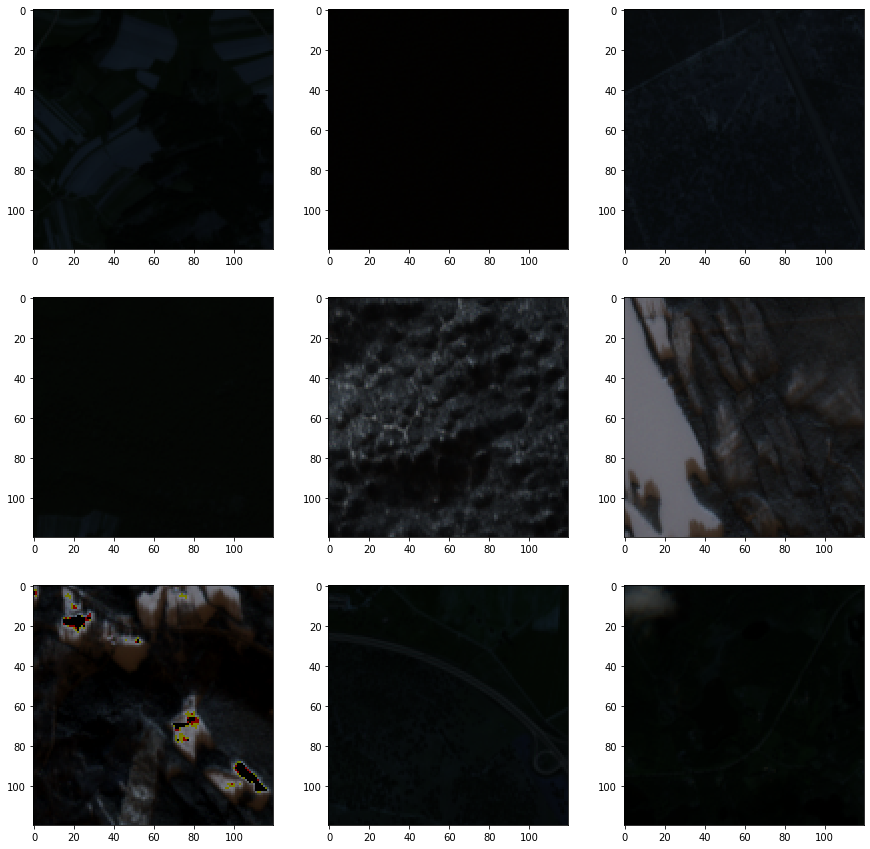

In [72]:
dim = 3
fig, axs = plt.subplots(dim, dim, **{'figsize': (15,  15)})

no_cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in no_cloud['image_prefix'].values]
for row_num, row_axs in enumerate(axs):
    for col_num, ax in enumerate(row_axs):
        img_num = dim * row_num + col_num * 300
        arr = np.load(no_cloud_npy_files[img_num])
        # This method makes the images too bright and colorful
#         rgb_img = calibrate_image(arr, stds, means)
        # normalizing gives a produces images that are too dark
#         rgb_img = ((arr - means) / stds * 255.).astype(np.int8)
        # scaling by .75 std away from the mean seems to do the best
#         rgb_img = arr / 1000 * 255.
#         rgb_img = np.clip(rgb_img, 0, 255).astype(np.uint8)    
#         rgb_img = (arr / (means + .5*stds) * 255.).astype(np.int8)        
        # min max produces images that are all black
#         rgb_img = ((arr - mins) / (maxs - mins) * 256.).astype(np.int8)        
        # dividing by 256 produces images that are too white
#         rgb_img = arr / 256

        ax.imshow(rgb_img)
#         text = list(map(lambda x: x.strip(), no_cloud.iloc[img_num]['labels'].replace('\'', '').replace('[', '').replace(']', '').split(',')))
        print(row_num, col_num, df.loc[no_cloud.iloc[img_num]['image_prefix']]['labels'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0 ['Complex cultivation patterns', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Peatbogs', 'Sea and ocean']
0 1 ['Coniferous forest', 'Mixed forest', 'Water bodies']
0 2 ['Water bodies']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 0 ['Sea and ocean']
1 1 ['Continuous urban fabric', 'Industrial or commercial units', 'Non-irrigated arable land']
1 2 ['Sport and leisure facilities', 'Non-irrigated arable land', 'Pastures', 'Broad-leaved forest', 'Mixed forest']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 0 ['Coniferous forest', 'Water bodies']
2 1 ['Pastures', 'Coniferous forest', 'Transitional woodland/shrub', 'Peatbogs']
2 2 ['Broad-leaved forest', 'Coniferous forest', 'Mixed forest', 'Peatbogs']


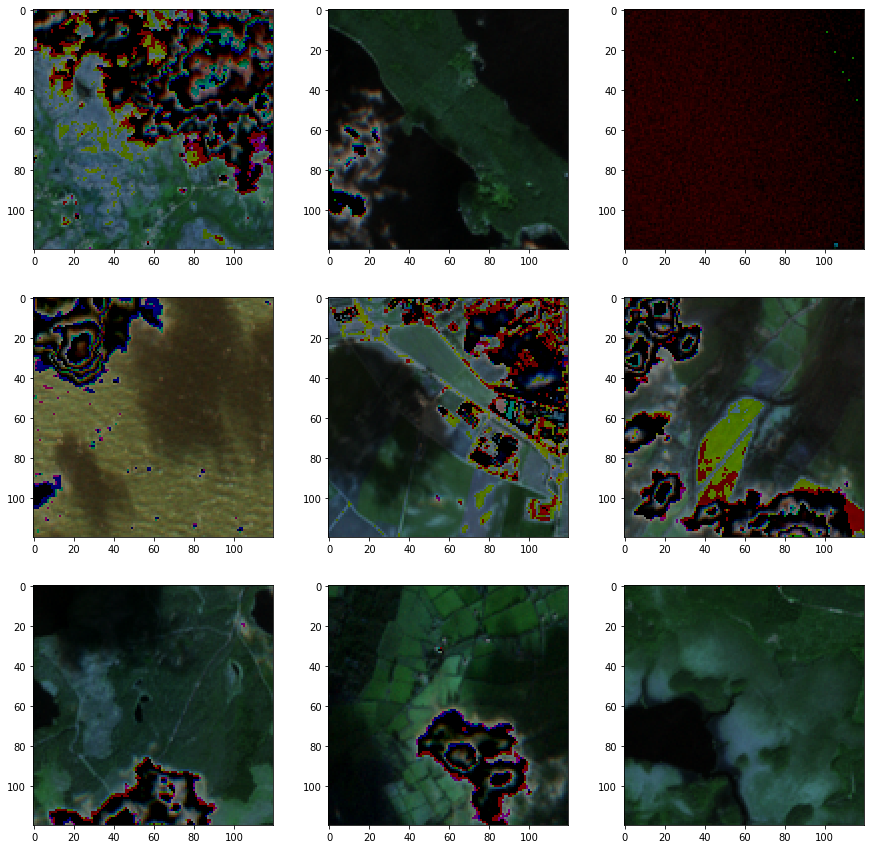

In [51]:
dim = 3
fig, axs = plt.subplots(dim, dim, **{'figsize': (15,  15)})

cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in cloud['image_prefix'].values]
for row_num, row_axs in enumerate(axs):
    for col_num, ax in enumerate(row_axs):
        img_num = dim * row_num + col_num * 20 
        arr = np.load(cloud_npy_files[img_num])
#         rgb_img = calibrate_image(arr, stds, meabsans)
        rgb_img = (arr / (means + .75*stds) * 256.).astype(np.int8)
        ax.imshow(rgb_img)
        print(row_num, col_num, df.loc[cloud.iloc[img_num]['image_prefix']]['labels'])

In [ ]:
dir(axs[0][0])